In [1]:
from typing import List, Dict, Mapping, Tuple

import chex
import jax
import jax.numpy as jnp
import jax.random as jrand
import flax.linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
import optax
import tensorflow as tf
import pdb
import functools

def println(*args):
  for arg in args:
    print(arg)


In [2]:
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()
jax.devices()

[CpuDevice(id=0)]

In [3]:
DEVICE_COUNT = len(jax.devices())
DEVICE_COUNT

1

In [4]:
BATCH_SIZE = 16

## Dataset pipline

In [5]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
x_train, x_test = ((x_train / 127.5) - 1), ((x_test / 127.5) -1)

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

def create_dataset():
  # Create a TensorFlow data pipeline for the training set
  train_dataset = (
      tf.data.Dataset
      .from_tensor_slices((x_train, y_train))
      .repeat()
      .shuffle(buffer_size=5000)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
      .as_numpy_iterator())

  # Create a TensorFlow data pipeline for the test set.
  test_dataset = (
      tf.data.Dataset
      .from_tensor_slices((x_test, y_test))
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
      .as_numpy_iterator())
  return train_dataset, test_dataset

def get_batch(dataset):
  images, labels = next(dataset)

  images, labels = jnp.array(images), jnp.array(labels)
  # images = jnp.reshape(images, (BATCH_SIZE, -1)) # flatten the images
  return images, labels

train_dataset, test_dataset = create_dataset()

11490434/11490434 [==============================] - 0s 0us/step


### test get_batch

In [6]:
test_images, test_labels = get_batch(train_dataset)
test_images.shape, test_labels.shape

((16, 28, 28), (16, 10))

## Modeling

In [ ]:
class Autoencoder(nn.Module):
  def setup(self):
    self.codebook = nn.Embed(num_embeddings=3, features=2)

  @nn.compact
  def __call__(self, x, training=False):
      # x = jnp.reshape(x, (28, 28, 1))

      # encoder
      x = nn.Conv(16, 4, strides=2, padding=1)(x)
      x = nn.BatchNorm()
      x = nn.relu(x)
      x = nn.Conv(16, 4, strides=2, padding=1)(x)
      x = nn.relu(x)

      # x = jnp.reshape(x, (-1)) # flatten
      # x = nn.Dense(3136)(x) # project to flat dimension of 3136, so that you can reconstruct 7x7x64 image from that by reshape

      # decoder
      # x = jnp.reshape(x, (7, 7, 64))

      x = nn.ConvTranspose(16, 4, strides=2, padding=1)(x)
      x = nn.relu(x)
      x = nn.ConvTranspose(1, 4, strides=2, padding=1)(x)
      x = nn.tanh(x)
      return x

In [46]:
import jax
import jax.numpy as jnp
import flax.linen as nn

class Autoencoder(nn.Module):
    num_embeddings: int = 3
    embedding_dim: int = 2
    beta: float = 0.2

    def setup(self):
        self.pre_quant_conv = nn.Conv(features=2, kernel_size=(1,), padding='SAME')
        self.embedding = nn.Embed(num_embeddings=self.num_embeddings, features=self.embedding_dim)
        self.post_quant_conv = nn.Conv(features=4, kernel_size=(1,), padding='SAME')

    @nn.compact
    def __call__(self, x, training: bool = True):
        # Encoder
        x = nn.Conv(features=16, kernel_size=(4,), strides=(2,), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=True)(x)
        x = nn.relu(x)
        x = nn.Conv(features=4, kernel_size=(4,), strides=(2,), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=True)(x)
        encoded_output = nn.relu(x)

        quant_input = self.pre_quant_conv(encoded_output)

        ## Quantization
        B, H, W, C = quant_input.shape
        quant_input = quant_input.reshape((B, H * W, C))

        # Compute pairwise distances and find index of nearest embedding
        min_encoding_indices = self._dist_batch(quant_input, self.embedding.embedding)

        # Select the embedding weights
        quant_out = self.embedding(min_encoding_indices)

        # Compute losses
        commitment_loss = jnp.mean((quant_out - quant_input)**2)
        codebook_loss = jnp.mean((quant_out - jax.lax.stop_gradient(quant_input))**2)
        quantize_losses = codebook_loss + self.beta * commitment_loss

        # Ensure straight through gradient
        quant_out = quant_input + jax.lax.stop_gradient(quant_out - quant_input)

        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C))

        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        x = nn.ConvTranspose(features=16, kernel_size=(4,), strides=(2,), padding='SAME')(decoder_input)
        x = nn.BatchNorm(use_running_average=True)(x)
        x = nn.relu(x)
        output = nn.ConvTranspose(features=1, kernel_size=(4,), strides=(2,), padding='SAME')(x)
        output = nn.tanh(output)

        return output, quantize_losses

    def _dist(self, quant_input_single_row, embedding_table):
      distances = jnp.sum((quant_input_single_row - embedding_table)**2, axis=-1)
      min_index = jnp.argmin(distances)
      return min_index

    def _dist_batch(self, quant_input_batch, embedding_table):
      quant_input_fn = jax.vmap(self._dist, in_axes=(0, None), out_axes=(0))
      quant_input_batch_fn = jax.vmap(quant_input_fn, in_axes=(0, None), out_axes=(0))
      return quant_input_batch_fn(quant_input_batch, embedding_table)


In [47]:
class TrainState(train_state.TrainState):
  key: jax.random.KeyArray

random_key = jax.random.PRNGKey(99)
random_key, random_subkey = jax.random.split(random_key)

model = Autoencoder()

test_image, test_label = test_images[0], test_labels[0]
test_image = test_image[jnp.newaxis, :, :, jnp.newaxis] # B, H, W, C
(output, quantize_losses), params = model.init_with_output(jrand.PRNGKey(99), test_image, training=False)
params = params["params"]

<ipython-input-47-196a9ef57f39>:2: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  key: jax.random.KeyArray


In [44]:
output.shape

(1, 28, 28, 1)

In [ ]:
def dist(quant_int_single_row, embedding_table):
    distances = jnp.sum((quant_int_single_row - embedding_table)**2, axis=-1)
    min_index = jnp.argmin(distances)
    return min_index

# Vectorize the dist function to apply it to each row of quant_input
vmap_dist = jax.vmap(dist, in_axes=(0, None))

# Compute the minimum distance embedding index for each row of quant_input
min_encoding_indices = vmap_dist(quant_input[0], embedding)

# Select the embedding weights using the minimum distance indices
quant_out = embedding[min_encoding_indices]

In [70]:
def dist(quant_int_single_row, embedding_table):
    distances = jnp.sum((quant_int_single_row - embedding_table)**2, axis=-1)
    min_index = jnp.argmin(distances)
    pdb.set_trace()
    return min_index


In [58]:
embedding = jnp.array([[ 0.24421199, -0.5446842 ],
       [-1.3313118 ,  1.1868978 ],
       [-0.4566962 , -0.8851884 ]], dtype=jnp.float32)

In [59]:
quant_input = jnp.array(Array[[[ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.31708723, -0.21942592],
        [ 0.1700311 , -0.11766236],
        [ 0.12728651, -0.08808289],
        [ 0.26512933, -0.1834708 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.1581337 , -0.10942929],
        [ 0.12632655,  0.09429599],
        [-0.0168417 , -0.0556844 ],
        [ 0.1048088 , -0.11608064],
        [ 0.33003643, -0.22838682],
        [ 0.13717403, -0.07405859],
        [ 0.2628734 , -0.18190968],
        [ 0.09461261, -0.06547239],
        [ 0.10639513, -0.0819018 ],
        [ 0.02587353,  0.036354  ],
        [ 0.15120953, -0.12543455],
        [ 0.36225837, -0.2506846 ],
        [ 0.13717403, -0.07405859],
        [ 0.1397198 , -0.09857887],
        [ 0.16406511,  0.15549637],
        [ 0.08410604, -0.092908  ],
        [ 0.20885997, -0.05551159],
        [ 0.23703988, -0.1839838 ],
        [ 0.33812135, -0.23398162],
        [ 0.13717403, -0.07405859],
        [ 0.13737643, -0.12540857],
        [ 0.11254933, -0.07788469],
        [ 0.09187608, -0.08960272],
        [ 0.25776714,  0.03961443],
        [ 0.24347015, -0.20782813],
        [ 0.33214882, -0.22984862],
        [ 0.13717403, -0.07405859],
        [ 0.18246934, -0.1695248 ],
        [ 0.20997788, -0.14530572],
        [ 0.3070701 , -0.21249402],
        [ 0.25311917, -0.01005739],
        [ 0.24619581, -0.21669793],
        [ 0.33214882, -0.22984862],
        [ 0.13717403, -0.07405859],
        [ 0.16925801, -0.148475  ],
        [ 0.23859407, -0.16510826],
        [ 0.29398474, -0.2034389 ],
        [ 0.25676575,  0.0462609 ],
        [ 0.24276787, -0.20497818],
        [ 0.33214882, -0.22984862],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.226907  ,  0.03736182],
        [ 0.23119563, -0.18013242],
        [ 0.34409386, -0.23811464],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.23244265, -0.16085145],
        [ 0.13930422,  0.04780931],
        [ 0.05841967, -0.06795694],
        [ 0.11167605, -0.12332304],
        [ 0.15127742, -0.09183382],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.19089764, -0.13210212],
        [ 0.23597534,  0.05774002],
        [-0.01117408, -0.05028145],
        [-0.02038556, -0.06740161],
        [-0.01401838, -0.04634955],
        [ 0.28657725, -0.19831286],
        [ 0.31898594, -0.22073984],
        [ 0.1018132 , -0.07045523],
        [ 0.09086595, -0.0831734 ],
        [-0.02180158, -0.07208344],
        [ 0.11764064, -0.0814079 ],
        [ 0.00818588, -0.02509928],
        [ 0.28657725, -0.19831286],
        [ 0.27151775, -0.18789162],
        [ 0.10471679, -0.07246453],
        [ 0.01354628,  0.00852497],
        [ 0.04236469, -0.04916535],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.21376935, -0.14792944],
        [ 0.13507682, -0.01404559],
        [-0.02820132, -0.09852063],
        [-0.0050306 , -0.01663286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.21376935, -0.14792944],
        [ 0.20357692,  0.0392635 ],
        [ 0.02613739, -0.08870228],
        [ 0.2153727 , -0.14903897],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.24968237, -0.17278142],
        [ 0.2259073 ,  0.09586637],
        [ 0.22444075, -0.1553141 ],
        [ 0.3296708 , -0.22813381],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3208667 , -0.22204134],
        [ 0.20405897, -0.14120981],
        [ 0.28133133, -0.19468267],
        [ 0.32893872, -0.2276272 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.13717403, -0.07405859],
        [ 0.28657725, -0.19831286],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.3218038 , -0.2226898 ],
        [ 0.32180387, -0.22268985],
        [ 0.13717403, -0.07405859]]], dtype=jnp.float32)

In [ ]:
def model_apply(params, inputs, training):
  return model.apply({"params": params}, inputs, training=training)

model_apply_batch = jax.vmap(model_apply, in_axes=(None, 0, None), out_axes=(0))

def forward_pass(params, state, batch):
  inputs, _ = batch # you are using reconstruction loss, so NO need of targets.
  reconstructed = state.apply_fn(
      params,
      inputs,
      True # training
    )

  PER_HOST_BATCH_SIZE = BATCH_SIZE // jax.device_count()

  reconstructed = jnp.reshape(reconstructed, (PER_HOST_BATCH_SIZE, -1)) # flatten the reconstructed to (32, 784)

  chex.assert_shape(inputs, (PER_HOST_BATCH_SIZE, 784))
  chex.assert_shape(reconstructed, (PER_HOST_BATCH_SIZE, 784))

  loss = (inputs - reconstructed) ** 2
  loss = loss.mean()
  return loss

def train_step(state, inputs, targets):
  batch = inputs, targets
  grad_fn = jax.value_and_grad(forward_pass, argnums=(0))  # differentiate wrt 0th pos argument.
  params = state.params
  loss, grads = grad_fn(state.params, state, batch)

  loss = jax.lax.pmean(loss, axis_name="devices")
  grads = jax.lax.pmean(grads, axis_name="devices")

  state = state.apply_gradients(grads=grads)
  return state, loss

opt = optax.adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model_apply_batch, params=params, tx=opt, key=random_key)

In [ ]:
# pmap the train_step.
train_step_pmap = jax.pmap(train_step, in_axes=(0, 0, 0), out_axes=(0), axis_name="devices")

In [ ]:
# replicate state
states = jax.device_put_replicated(state, jax.local_devices())

In [ ]:
# Training loop
num_epochs = 1
steps_per_epoch = 1 # len(x_train) // BATCH_SIZE

for epoch in range(num_epochs):
    print("epoch: ", epoch)
    train_dataset, _ = create_dataset()

    for step in range(steps_per_epoch):
        inputs, targets = get_batch(train_dataset)

        # create device dimension for minibatch
        inputs = inputs.reshape((jax.device_count(), -1, inputs.shape[-1]))
        targets = targets.reshape((jax.device_count(), -1, targets.shape[-1]))

        states, loss = train_step_pmap(states, inputs, targets)
        print("loss", loss[0]) if step%100==0 else None

epoch:  0
loss 0.23077835


In [ ]:
state = jax.tree_map(lambda x: x[0], states)

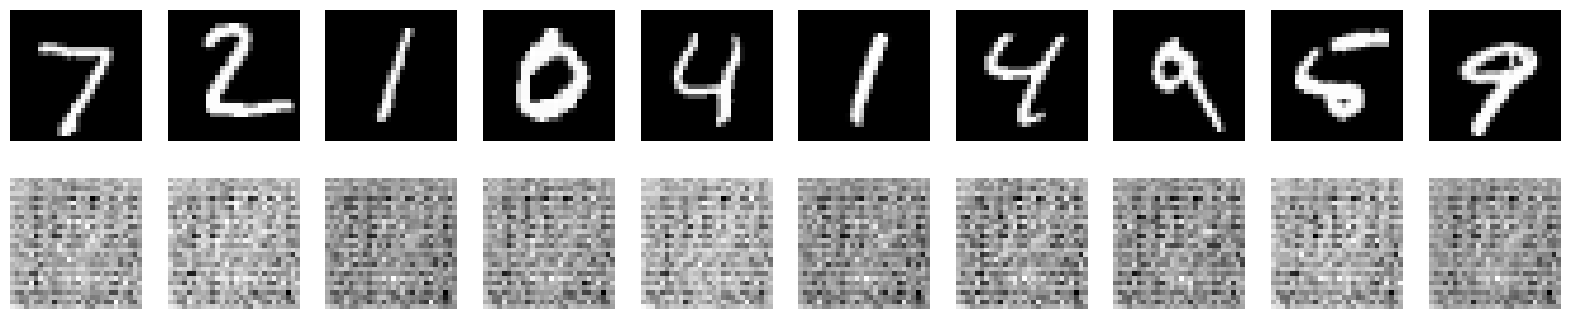

In [ ]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, params, batch, n=10):
    inputs, _ = batch
    reconstructed = state.apply_fn(params, inputs, False)
    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Visualize some reconstructionsmodel_apply_batch
train_dataset, test_dataset = create_dataset()
plot_reconstructions(model, state.params, get_batch(test_dataset))
